# BONSAI + MAP-SAAS Tutorial: 

This tutorial demonstrates how to use **BONSAI** (Bayesian Optimization with Natural Simplicity and Interpretability) with **MAP-SAAS** to optimize the high-dimensional Hartmann50 benchmark problem and simplify proposals in order to only make necessary chagnes from the default (status quo) parameter values.

## Overview

- **Hartmann50**: A 50-dimensional synthetic benchmark where only 6 dimensions are relevant (the true Hartmann function), and 44 dimensions are "dummy" irrelevant dimensions.
- **BONSAI**: A Bayesian optimization method that removes irrelevant parameter changes to simplify proposals from Ax. This simplifies the proposals so that they change fewer parameters, making the proposals more interpretable and more likely to avoid regressions in metrics not captured in the optimization objective.
- **MAP-SAAS**: A fast Gaussian process model that has a SAAS (sparsity) prior.

This combination is particularly powerful for high-dimensional problems with low effective dimensionality.

These methods were proposed in **[Daulton, et al. BONSAI: Bayesian Optimization with Natural Simplicity and Interpretability, ArXiv, 2026](https://arxiv.org/abs/2602.07144)**.

## 1. Imports

In [ ]:
import numpy as np
import torch

from ax.api.client import Client
from ax.api.configs import RangeParameterConfig
from ax.api.utils.generation_strategy_dispatch import choose_generation_strategy
from ax.api.utils.structs import GenerationStrategyDispatchStruct

# Model configuration
from ax.generators.torch.botorch_modular.surrogate import ModelConfig

# BoTorch model (the key component for BONSAI)
from botorch.models.map_saas import EnsembleMapSaasSingleTaskGP

print(f"Using torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

## 2. Understanding the Components

### 2.1 Hartmann50 Problem

The Hartmann50 problem is a 50-dimensional optimization problem where:
- The first 6 dimensions contain the actual Hartmann function (which has 6 local minima)
- The remaining 44 dimensions are "dummy" and do not affect the objective value
- This makes it an ideal test case for algorithms that can identify and focus on relevant dimensions
- The global minimum is approximately -3.32237

### 2.2 A MAP-SAAS model (`EnsembleMapSaasSingleTaskGP`)

This is a Gaussian Process model that uses an ensemble of independent GPs with different samples of the global sparsity level (integrating over the global sparsity level). It uses Maximum A Posteriori (MAP) estimation for fitting each member in the ensemble, which is significantly faster than using MCMC as in SAASBO. It levers the same sparsity prior as SAASBO, but is significantly faster.

### 2.3 BONSAI

BONSAI (Bayesian Optimization with Natural Simplicity and Interpretability) is a technique for post-processing candidates generated by BO to prune irrelevant parameter changes from the default (status quo or target) values. It is compatabile with any acquisition function and is easily enabled by specifying `simplify_parameter_changes=True` in Ax.

## 3. Set Up the Hartmann50 Optimization Problem

We'll create a Client and configure the experiment with 50 parameters.

In [29]:
# Create a client
client = Client()

# Define 50 parameters (x0 through x49) in the unit hypercube [0, 1]
parameters = [
    RangeParameterConfig(
        name=f"x{i}",
        parameter_type="float",
        bounds=(0.0, 1.0),
    )
    for i in range(50)
]

# Configure the experiment
client.configure_experiment(parameters=parameters)

# Define the center of the search space as the pruning target
# Parameters that are "pruned" will be set to these default values
pruning_target = {f"x{i}": 0.5 for i in range(50)}

# Configure optimization to minimize the objective
metric_name = "hartmann"
objective = f"-{metric_name}"  # Negative sign indicates minimization
client.configure_optimization(
    objective=objective,
    pruning_target_parameterization=pruning_target,
)

print(f"Experiment configured with {len(parameters)} parameters")
print(f"Objective: minimize {metric_name}")
print(f"Pruning target: center of search space (0.5 for all parameters)")

Experiment configured with 50 parameters
Objective: minimize hartmann
Pruning target: center of search space (0.5 for all parameters)


## 4. Define the Hartmann50 Objective Function

The Hartmann50 function uses the 6D Hartmann function on the first 6 dimensions, with 44 dummy dimensions that don't affect the output.

In [30]:
from botorch.test_functions import Hartmann

# Create the 6D Hartmann function
hartmann_6d: Hartmann = Hartmann(dim=6, negate=False)


def hartmann50(**parameters) -> float:
    """Evaluate the Hartmann50 function.

    Only the first 6 dimensions (x0-x5) affect the output.
    The remaining 44 dimensions (x6-x49) are ignored.

    Args:
        **parameters: Dict of parameter values (x0 through x49)

    Returns:
        The Hartmann function value (to be minimized).
    """
    # Extract the first 6 parameters that actually matter
    x = torch.tensor([[parameters[f"x{i}"] for i in range(6)]], dtype=torch.double)
    return hartmann_6d(x).item()


# Test the function
test_params = {f"x{i}": 0.5 for i in range(50)}
print(f"Test evaluation at center: {hartmann50(**test_params):.4f}")
print("Global optimum is approximately: -3.32237")

Test evaluation at center: -0.5053
Global optimum is approximately: -3.32237


## 5. Configure the Generation Strategy with BONSAI and MAP-SAAS

We use `choose_generation_strategy` with `GenerationStrategyDispatchStruct(method="custom", simplify_parameter_changes=True)` to specify that we want to use BONSAI and we specify to use `EnsembleMapSaasSingleTaskGP`` to leverage MAP-SAAS.

In [35]:
# Configuration parameters
NUM_SOBOL_TRIALS = 10  # Number of initial quasi-random trials

# Configure the model for BONSAI with MAP-SAAS
model_config = ModelConfig(
    botorch_model_class=EnsembleMapSaasSingleTaskGP,
    name="BONSAI",
)

# Create the BONSAI generation strategy using choose_generation_strategy
generation_strategy = choose_generation_strategy(
    struct=GenerationStrategyDispatchStruct(
        method="custom",
        initialization_budget=NUM_SOBOL_TRIALS,
        initialize_with_center=True,
        simplify_parameter_changes=True,
    ),
    model_config=model_config,
)

# Set the generation strategy on the client
client.set_generation_strategy(generation_strategy=generation_strategy)

print(f"Generation strategy configured: {generation_strategy.name}")
print("  - 1 Center trial")
print(f"  - {NUM_SOBOL_TRIALS - 1} Sobol trials")
print("  - BONSAI with MAP-SAAS")
print("  - simplify_parameter_changes=True (pruning irrelevant dimensions)")

Generation strategy configured: Center+Sobol+MBM:BONSAI
  - 1 Center trial
  - 9 Sobol trials
  - BONSAI with MAP-SAAS
  - simplify_parameter_changes=True (pruning irrelevant dimensions)


## 6. Run the Optimization Loop

In [32]:
import logging

# Set the Ax logger to show only warnings and errors.
logging.getLogger("ax.api.client").setLevel(logging.WARNING)

# Total number of trials
TOTAL_TRIALS = 50

# Track best values for visualization
best_values = []
all_values = []
current_best = float("inf")

print(f"Starting optimization with {TOTAL_TRIALS} trials...")
print("-" * 60)

for trial_idx in range(TOTAL_TRIALS):
    # Get the next trial(s) from the generation strategy
    trials = client.get_next_trials(max_trials=1)

    for index, parameters in trials.items():
        # Evaluate the objective function
        result = hartmann50(**parameters)
        all_values.append(result)

        # Update best value (we're minimizing)
        if result < current_best:
            current_best = result
            improvement_marker = " *NEW BEST*"
        else:
            improvement_marker = ""

        best_values.append(current_best)

        # Report the result back to Ax
        client.complete_trial(
            trial_index=index,
            raw_data={metric_name: result},
        )

        # Determine which phase we're in
        if trial_idx == 0:
            phase = "Center"
        elif trial_idx < NUM_SOBOL_TRIALS:
            phase = "Sobol"
        else:
            phase = "BONSAI"

        # Print progress (every 5 trials or when there's improvement)
        if trial_idx % 5 == 0 or improvement_marker:
            print(
                f"Trial {trial_idx + 1:3d}/{TOTAL_TRIALS} [{phase:6s}]: "
                f"value = {result:8.4f}, best = {current_best:8.4f}{improvement_marker}"
            )

print("-" * 60)
print("Optimization complete!")
print(f"Best value found: {current_best:.4f}")
print("Global optimum: -3.32237")
print(f"Gap to optimum: {current_best - (-3.32237):.4f}")

Starting optimization with 50 trials...
------------------------------------------------------------
Trial   1/50 [Center]: value =  -0.5053, best =  -0.5053 *NEW BEST*
Trial   4/50 [Sobol ]: value =  -1.2127, best =  -1.2127 *NEW BEST*


Trial   6/50 [Sobol ]: value =  -0.0301, best =  -1.2127


[W 260130 15:38:34 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  11/50 [BONSAI]: value =  -0.7886, best =  -1.2127


[W 260130 15:38:36 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:40 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:45 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:47 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:49 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  16/50 [BONSAI]: value =  -0.7900, best =  -1.2127


[W 260130 15:38:52 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  17/50 [BONSAI]: value =  -2.3504, best =  -2.3504 *NEW BEST*


[W 260130 15:38:54 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:57 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:38:59 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:01 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  21/50 [BONSAI]: value =  -2.5353, best =  -2.5353 *NEW BEST*


[W 260130 15:39:04 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:06 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:08 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:10 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  25/50 [BONSAI]: value =  -2.8627, best =  -2.8627 *NEW BEST*


[W 260130 15:39:12 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  26/50 [BONSAI]: value =  -2.0271, best =  -2.8627


Trial  27/50 [BONSAI]: value =  -2.9566, best =  -2.9566 *NEW BEST*


[W 260130 15:39:17 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  28/50 [BONSAI]: value =  -2.9679, best =  -2.9679 *NEW BEST*


[W 260130 15:39:18 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:21 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:23 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  31/50 [BONSAI]: value =  -2.9697, best =  -2.9697 *NEW BEST*


[W 260130 15:39:28 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:39:38 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  33/50 [BONSAI]: value =  -2.9826, best =  -2.9826 *NEW BEST*


[W 260130 15:39:57 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:06 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:11 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  36/50 [BONSAI]: value =  -2.9701, best =  -2.9826


[W 260130 15:40:15 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:19 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:23 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:26 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:29 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  41/50 [BONSAI]: value =  -2.9673, best =  -2.9826


[W 260130 15:40:42 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:40:55 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:41:08 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  44/50 [BONSAI]: value =  -3.1051, best =  -3.1051 *NEW BEST*


[W 260130 15:41:11 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  45/50 [BONSAI]: value =  -3.1220, best =  -3.1220 *NEW BEST*


[W 260130 15:41:19 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  46/50 [BONSAI]: value =  -2.8086, best =  -3.1220


[W 260130 15:41:21 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


Trial  47/50 [BONSAI]: value =  -3.1354, best =  -3.1354 *NEW BEST*


[W 260130 15:41:27 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:41:32 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


[W 260130 15:41:36 cholesky:40] A not p.d., added jitter of 1.0e-08 to the diagonal


------------------------------------------------------------
Optimization complete!
Best value found: -3.1354
Global optimum: -3.32237
Gap to optimum: 0.1870


## 7. Visualize Optimization Performance

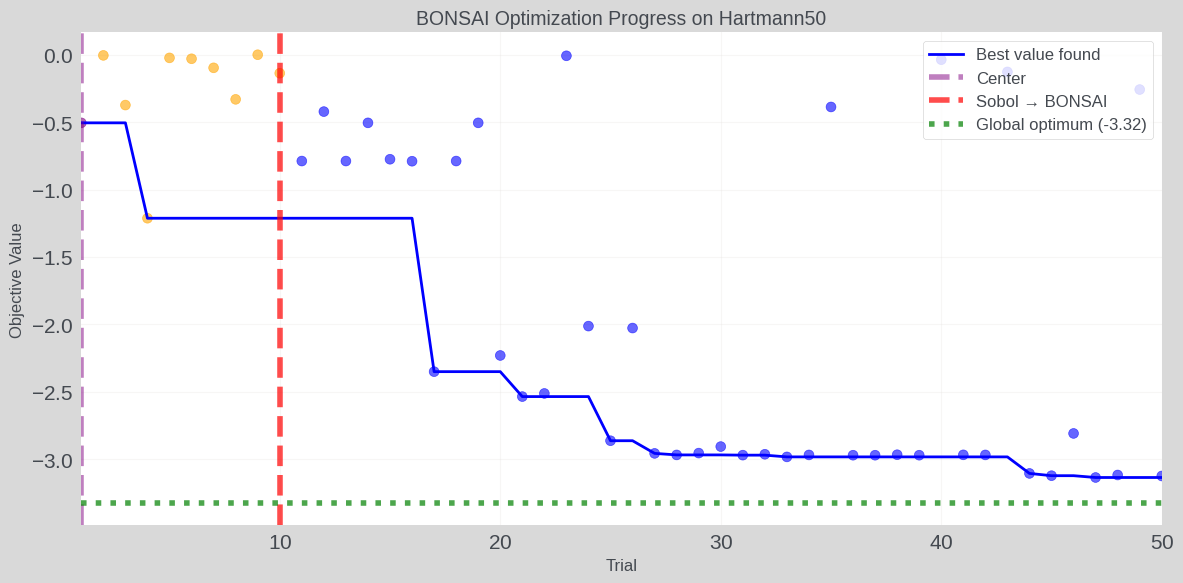

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

trials_range = range(1, len(best_values) + 1)

# Plot best values over trials (convergence plot)
ax.plot(trials_range, best_values, 'b-', linewidth=2, label='Best value found')
ax.axvline(x=1, color='purple', linestyle='--', alpha=0.5, label='Center')
ax.axvline(x=NUM_SOBOL_TRIALS, color='r', linestyle='--', alpha=0.7, label='Sobol → BONSAI')
ax.axhline(y=-3.32237, color='g', linestyle=':', alpha=0.7, label='Global optimum (-3.32)')

# Scatter plot of all trial values
colors = ['purple'] + ['orange'] * (NUM_SOBOL_TRIALS - 1) + ['blue'] * (TOTAL_TRIALS - NUM_SOBOL_TRIALS)
ax.scatter(trials_range, all_values, c=colors, alpha=0.6, s=50)

ax.set_xlabel('Trial', fontsize=12)
ax.set_ylabel('Objective Value', fontsize=12)
ax.set_title('BONSAI Optimization Progress on Hartmann50', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([1, TOTAL_TRIALS])

plt.tight_layout()
plt.show()

## 8. Analyze Objective vs Simplicity trade-offs

One of the key benefits of BONSAI is that it can prune irrelevant parameters (set them to default values). Let's analyze how the number of active parameters relates to the best objective value found.

Collected data for 50 trials

Number of active parameters per trial:
  Min: 0
  Max: 50
  Mean: 12.8


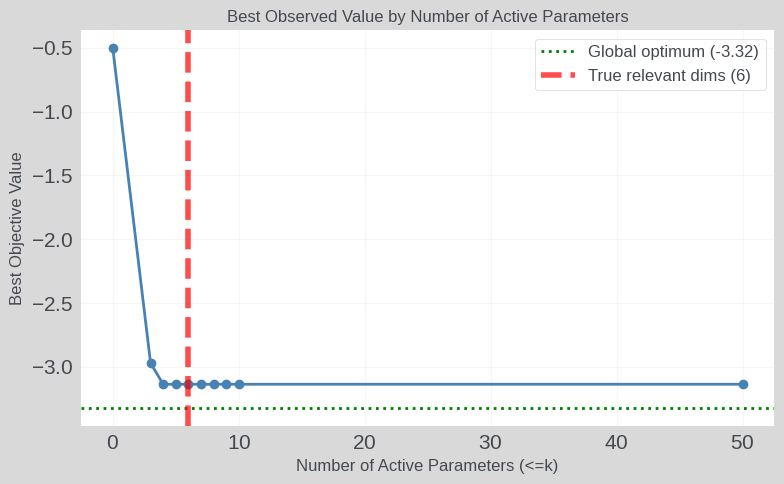

In [41]:
def count_active_parameters(
    parameters: dict[str, float], default_value: float = 0.5, tol: float = 1e-6
) -> int:
    """Count the number of parameters that differ from the default value."""
    return sum(1 for v in parameters.values() if abs(v - default_value) > tol)


# Get all trials and their parameters
experiment = client._experiment
trials_data = []

for trial_index, trial in experiment.trials.items():
    arm = trial.arm
    if arm is not None:
        params = arm.parameters
        num_active = count_active_parameters(params)
        # Get the objective value for this trial
        trial_data = trial.lookup_data()
        if not trial_data.df.empty:
            obj_value = trial_data.df[trial_data.df["metric_name"] == metric_name][
                "mean"
            ].values[0]
            trials_data.append(
                {
                    "trial_index": trial_index,
                    "num_active_params": num_active,
                    "objective_value": obj_value,
                }
            )

# Convert to arrays for plotting
num_active_params = [d["num_active_params"] for d in trials_data]

print(f"Collected data for {len(trials_data)} trials")
print("\nNumber of active parameters per trial:")
print(f"  Min: {min(num_active_params)}")
print(f"  Max: {max(num_active_params)}")
print(f"  Mean: {np.mean(num_active_params):.1f}")

# Compute best observed objective value for each number of active parameters
from collections import defaultdict

# Group trials by number of active parameters
params_to_best_value = defaultdict(lambda: float('inf'))
for d in trials_data:
    n_active = d["num_active_params"]
    obj_val = d["objective_value"]
    if obj_val < params_to_best_value[n_active]:
        params_to_best_value[n_active] = obj_val

# Sort by number of active parameters
sorted_n_active = sorted(params_to_best_value.keys())

fig, ax = plt.subplots(figsize=(8, 5))

# Modify best_values_by_n_active to represent the best objective for any point with <=k parameters active
cumulative_best_values = []
current_best = float('inf')
for n in sorted_n_active:
    current_best = min(current_best, params_to_best_value[n])
    cumulative_best_values.append(current_best)

# Line plot: Best observed value versus number of active parameters based on cumulative best values
ax.plot(sorted_n_active, cumulative_best_values, color='steelblue', marker='o', linestyle='-', linewidth=2)
ax.axhline(y=-3.32237, color='g', linestyle=':', linewidth=2, label='Global optimum (-3.32)')
ax.axvline(x=6, color='r', linestyle='--', alpha=0.7, label='True relevant dims (6)')
ax.set_xlabel('Number of Active Parameters (<=k)', fontsize=12)
ax.set_ylabel('Best Objective Value', fontsize=12)
ax.set_title('Best Observed Value by Number of Active Parameters', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Key Takeaways

### Why BONSAI + MAP-SAAS?

1. **MAP-SAAS**: MAP-SAAS is a variant of the Sparse Axis Aligned Subspace prior (Eriksson & Jankowiak. High-dimensional Bayesian optimization with sparse axis-aligned subspace, UAI, 2021), and places a half-Cauchy prior on the GP lengthscales.  As a result, SAAS models encourage model sparsity, where less relevant inputs are driven toward long lengthscales.  This improves performance on high-dimensional tasks, and is synergistic with BONSAI.  Standard SAAS models use a time consuming, Bayesian (MCMC) inference procedure; MAP-SAAS provides many of the benefits of the fully Bayesian MAP SAAS by ensembling over just a few models estimated via MAP with significantly lower computational costs.

2. **BONSAI**: BONSAI prunes irrelevant dimensions via `simplify_parameter_changes=True` and sets them to the `pruning_target_parameterization` (the status quo/default/production values or a target point of interest). This simplifies the proposals so that they change fewer parameters, making the proposals more interpretable and more likely to avoid regressions in metrics not captured in the optimization objective.

### When to Use This Approach
- **Real-world optimization** where simple, interpretable changes are desired.